In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import  models, layers
from tensorflow.keras.initializers import glorot_uniform

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/Datastets/Splitted/train",
        shuffle = True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/Datastets/Splitted/val",
        shuffle = True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/drive/MyDrive/Datastets/Splitted/test",
        shuffle = True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Found 32083 files belonging to 33 classes.
Found 4002 files belonging to 33 classes.
Found 4000 files belonging to 33 classes.


## VGG16

In [ ]:
VGG16 = models.Sequential([
                layers.experimental.preprocessing.Resizing(256, 256),
                layers.experimental.preprocessing.Rescaling(1.0/255),
                layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
                layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'),
                layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'),
                layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
                layers.MaxPool2D(pool_size=(2,2),strides=(2,2), padding='valid'),
                layers.Flatten(),
                layers.Dense(4096, activation='relu'),
                layers.Dense(4096, activation='relu'),
                layers.Dense(4096, activation='relu'),
                layers.Dense(units=33, activation='softmax')
])
VGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=10**(-7)),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_logger = CSVLogger('VGG16_from_scractch_model.csv', separator=",", append=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = VGG16.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[history_logger, earlyStopping])

VGG16.save('VGG16_from_scratch_model.keras')

Epoch 1/50


## ResNet50
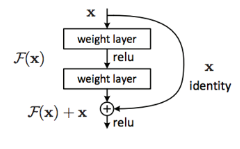

In [ ]:
def identity_block(X, filters, block, stage, stride=1):
  X_shortcut = X

  name_conv = f'resBlock{block}_stage{stage}'
  name_BN = f'BNBlock{block}_stage{stage}'

  # First layer
  X = layers.Conv2D(filters[0], kernel_size=(1,1), padding='valid', strides=(stride,stride),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'a')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'a')(X)
  X = layers.Activation('relu')(X)

  # Second layer
  X = layers.Conv2D(filters[1], kernel_size=(3,3), padding='same', strides=(1,1),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'b')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'b')(X)
  X = layers.Activation('relu')(X)

  # Third layer
  X = layers.Conv2D(filters[2], kernel_size=(1,1), padding='valid', strides=(stride,stride),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'c')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'c')(X)

  # Skip connection
  X = layers.Add()([X, X_shortcut])
  X = layers.Activation('relu')(X)

  return X


def convolutional_block(X, filters, block, stage, stride=1):
  X_shortcut = X

  name_conv = f'resBlock{block}_stage{stage}'
  name_BN = f'BNBlock{block}_stage{stage}'

  # First layer
  X = layers.Conv2D(filters[0], kernel_size=(1,1), padding='valid', strides=(stride,stride),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'a')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'a')(X)
  X = layers.Activation('relu')(X)

  # Second layer
  X = layers.Conv2D(filters[1], kernel_size=(3,3), padding='same', strides=(1,1),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'b')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'b')(X)
  X = layers.Activation('relu')(X)

  # Third layer
  X = layers.Conv2D(filters[2], kernel_size=(1,1), padding='valid', strides=(1,1),
                    kernel_initializer=glorot_uniform(seed=0), name=name_conv+'c')(X)
  X = layers.BatchNormalization(axis=3, name=name_BN+'c')(X)

  # Skip connection with convolution
  X_shortcut = layers.Conv2D(filters=filters[2], kernel_size=(1,1), strides=(stride,stride), padding='valid',
                             kernel_initializer=glorot_uniform(seed=0), name=name_conv+'a_0')(X_shortcut)
  X_shortcut = layers.BatchNormalization(axis=3, name=name_BN+'a_0')(X_shortcut)

  X = layers.Add()([X, X_shortcut])
  X = layers.Activation('relu')(X)

  return X

def ResNet50_model(input_shape=(256, 256, 3)):
  input = layers.Input(input_shape)
  input = layers.experimental.preprocessing.Resizing(256, 256)(input)
  input = layers.experimental.preprocessing.Rescaling(1.0/255)(input)

  X = layers.ZeroPadding2D((3, 3))(input)
  X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2,2), padding='valid',
                            kernel_initializer=glorot_uniform(seed=0))(X)
  X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(X)

  # 3xBlock 1
  X = convolutional_block(X, filters=[64, 64, 256], block='1', stage='1', stride=1)
  X = identity_block(X, filters=[64, 64, 256], block='1', stage='2', stride=1)
  X = identity_block(X, filters=[64, 64, 256], block='1', stage='3', stride=1)

  # 4xBlock 2
  X = convolutional_block(X, filters=[128, 128, 256], block='2', stage='1', stride=2)
  X = identity_block(X, filters=[128, 128, 256], block='2', stage='2', stride=1)
  X = identity_block(X, filters=[128, 128, 256], block='2', stage='3', stride=1)
  X = identity_block(X, filters=[128, 128, 256], block='2', stage='4', stride=1)

  # 6xBlock 3
  X = convolutional_block(X, filters=[256, 256, 1024], block='3', stage='1', stride=2)
  X = identity_block(X, filters=[256, 256, 1024], block='3', stage='2', stride=1)
  X = identity_block(X, filters=[256, 256, 1024], block='3', stage='3', stride=1)
  X = identity_block(X, filters=[256, 256, 1024], block='3', stage='4', stride=1)
  X = identity_block(X, filters=[256, 256, 1024], block='3', stage='5', stride=1)
  X = identity_block(X, filters=[256, 256, 1024], block='3', stage='6', stride=1)

  # 3xBlock 4
  X = convolutional_block(X, filters=[512, 512, 2048], block='4', stage='1', stride=2)
  X = identity_block(X, filters=[512, 512, 2048], block='4', stage='2', stride=1)
  X = identity_block(X, filters=[512, 512, 2048], block='4', stage='3', stride=1)

  X = layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)
  X = layers.Flatten()(X)

  X = layers.Dense(units=33, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
  model = models.Model(inputs=input, outputs=X)

  return model


In [ ]:
ResNet50 = ResNet50_model((IMAGE_SIZE, IMAGE_SIZE, 3))

ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=10**(-7)),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_logger = CSVLogger('ResNet50_from_scractch_model.csv', separator=",", append=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = ResNet50.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[history_logger, earlyStopping])

VGG16.save('ResNet50_from_scratch_model.keras')

Epoch 1/50
  3/125 [..............................] - ETA: 58:26 - loss: 120.8501 - accuracy: 0.1042

## Xception

In [ ]:
def Block1_entry_flow(X, filters):
  X_shortcut = X

  X = layers.SeparableConv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.SeparableConv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(X)

  # Skip connection with convolution
  X_shortcut = layers.Conv2D(filters, kernel_size=(1,1), strides=(2,2), padding='same')(X_shortcut)
  X_shortcut = layers.BatchNormalization()(X_shortcut)

  X = layers.Add()([X, X_shortcut])
  X = layers.Activation('relu')(X)

  return X


def ResidualBlock(X):
  X_shortcut = X
  X = layers.SeparableConv2D(728, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.SeparableConv2D(728, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.SeparableConv2D(728, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  residual_block_output = layers.Add()([X, X_shortcut])
  residual_block_output = layers.Activation('relu')(residual_block_output)

  return residual_block_output


def Xception_model(input_shape=(256, 256, 3)):
  input = layers.Input(input_shape)
  input = layers.experimental.preprocessing.Resizing(256, 256)(input)
  input = layers.experimental.preprocessing.Rescaling(1.0/255)(input)

  X = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='valid')(input)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.Conv2D(64,kernel_size=(3,3), strides=(1,1), padding='valid')(input)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  # 3xBlock1_entry_flow
  X = Block1_entry_flow(X, 128)
  X = Block1_entry_flow(X, 256)
  X = Block1_entry_flow(X, 728)

  # 8xResidualBlock
  for _ in range(8):
    X = ResidualBlock(X)

  # Block 2 with residual connection
  X_shortcut = X
  X = layers.SeparableConv2D(728, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.SeparableConv2D(1024, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(X)

  # Skip connection with convolution
  X_shortcut = layers.Conv2D(1024, kernel_size=(1,1), strides=(2,2), padding='same')(X_shortcut)
  X_shortcut = layers.BatchNormalization()(X_shortcut)

  X = layers.Add()([X, X_shortcut])
  X = layers.Activation('relu')(X)

  X = layers.SeparableConv2D(1536, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)
  X = layers.SeparableConv2D(2048, kernel_size=(3,3), strides=(1,1), padding='same')(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.GlobalAvgPool2D()(X)
  X = layers.Dense(units=33, activation='softmax')(X)
  model = models.Model(inputs=input, outputs=X)

  return model

In [ ]:
Xception = Xception_model((IMAGE_SIZE, IMAGE_SIZE, 3))

Xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=10**(-7)),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_logger = CSVLogger('Xception_from_scractch_model.csv', separator=",", append=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = Xception.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[history_logger, earlyStopping])

VGG16.save('Xception_from_scratch_model.keras')

Epoch 1/50


## Inception-V3

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(
                                include_top=False,
                                weights=None,
                                input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

InceptionV3.trainable = True
# Create a new 'top' of the model.
inputs = tf.keras.Input(shape=((IMAGE_SIZE, IMAGE_SIZE, 3)))
top_model = tf.keras.applications.inception_v3.preprocess_input(inputs)
top_model = InceptionV3(top_model)
top_model = layers.Flatten(name="flatten")(top_model)
output_layer = layers.Dense(33, activation='softmax')(top_model)

model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=10**(-7)),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

history_logger = CSVLogger('InceptionV3_from_scratch_model_Adam.csv', separator=",", append=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[history_logger, earlyStopping])

model.save('InceptionV3_from_scratch_model_Adam.keras')


Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 19.3994 - accuracy: 0.1100

## DenseNet201

In [ ]:
DenseNet201 = tf.keras.applications.DenseNet201(
                                include_top=False,
                                weights=None,
                                input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

DenseNet201.trainable = True
# Create a new 'top' of the model.
inputs = tf.keras.Input(shape=((IMAGE_SIZE, IMAGE_SIZE, 3)))
top_model = tf.keras.applications.densenet.preprocess_input(inputs)
top_model = DenseNet201(top_model)
top_model = layers.Flatten(name="flatten")(top_model)
output_layer = layers.Dense(33, activation='softmax')(top_model)

model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=10**(-7)),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

history_logger = CSVLogger('DenseNet201_from_scratch_model_Adam.csv', separator=",", append=True)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(test_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[history_logger, earlyStopping])

model.save('DenseNet201_from_scratch_model_Adam.keras')

Epoch 1/50
